In [3]:
import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')

[autoreload of huggingface_hub failed: Traceback (most recent call last):
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __dir__() requires a code object with 1 free vars, not 0
]
[autoreload of huggingface_hub.utils._headers failed: Traceback 

In [5]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from llc import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# t.set_grad_enabled(False)
device = t.device("cuda" if t.cuda.is_available() else "cpu")

MODEL_DIR = '2025-01-30_22-25-39_S4_A4x2_MLP2_32_ubias_wd2e-5_10000'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
# models, params = load_models(local_dir, sel=0)

# IMPORTANT: set seed before creating data (which samples train_data)
t.manual_seed(params.seed)
np.random.seed(params.seed)
random.seed(params.seed)

data = GroupData(params)
train_x = t.tensor(data.train_data)[:,:2]
train_z = t.tensor(data.train_data)[:,2]

100%|██████████| 600/600 [01:52<00:00,  5.35it/s]


Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4), Z(2))
Train set size: 336/576 (0.58)


In [64]:
train = t.tensor(data.train_data).to(device)
x_train = train[:,:2]
z_train = train[:,2]
x_test = t.tensor(list(product(range(data.N), repeat=2)), device=device)

outs = {'train': [], 'test': []}
for model in tqdm(models):
    model = model.to(device)
    outs['train'].append(model(x_train).detach().cpu())
    outs['test'].append(model(x_test).detach().cpu())

  0%|          | 0/600 [00:00<?, ?it/s]

In [50]:
outs['train'][0].shape, outs['test'][0].shape

(torch.Size([336, 1000, 24]), torch.Size([576, 1000, 24]))

In [51]:
l2_deltas = {}
kl_deltas = {}
acc_deltas = {}

for key in ['train', 'test']:
    l2_deltas[key] = []
    kl_deltas[key] = []
    acc_deltas[key] = []
    print(key)
    for out0, out1 in tqdm(zip(outs[key][:-1], outs[key][1:]), total=len(outs[key])-1):
        # out0, out1 are (batch, instance, class)
        l2_deltas[key].append(t.norm(out0 - out1, dim=-1).mean(dim=0))
        kl_deltas[key].append(
            t.nn.functional.kl_div(
                t.nn.functional.log_softmax(out0, dim=-1), t.nn.functional.softmax(out1, dim=-1), log_target=True, reduction='none'
            ).sum(dim=-1).mean(dim=0)
        )
        acc_deltas[key].append(
            (out0.argmax(dim=-1) != out1.argmax(dim=-1)).float().mean(dim=0)
        )
    l2_deltas[key] = t.stack(l2_deltas[key])
    kl_deltas[key] = t.stack(kl_deltas[key])
    acc_deltas[key] = t.stack(acc_deltas[key])

train


  0%|          | 0/599 [00:00<?, ?it/s]

test


  0%|          | 0/599 [00:00<?, ?it/s]

In [52]:
tvs = {
    f'{name}_{key}': deltas[key][-100:].mean(dim=0)
    for key in ['train', 'test']
    for name, deltas in zip(['l2', 'kl', 'acc'], [l2_deltas, kl_deltas, acc_deltas])
}

In [53]:
ACC_THRESH = 0.999
loss_dict = test_loss(models[-1].to(device), data)
g0_grokked = (loss_dict['G0_acc'] > ACC_THRESH)
g1_grokked = (loss_dict['G1_acc'] > ACC_THRESH)
grokked = g0_grokked | g1_grokked
print('G0 grokked', g0_grokked.sum())
print('G1 grokked', g1_grokked.sum())

G0 grokked tensor(53, device='cuda:0')
G1 grokked tensor(6, device='cuda:0')


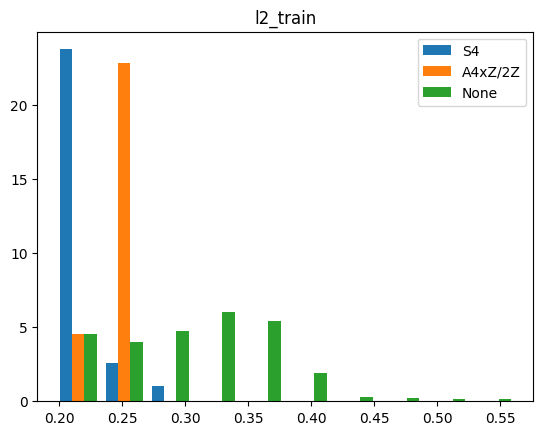

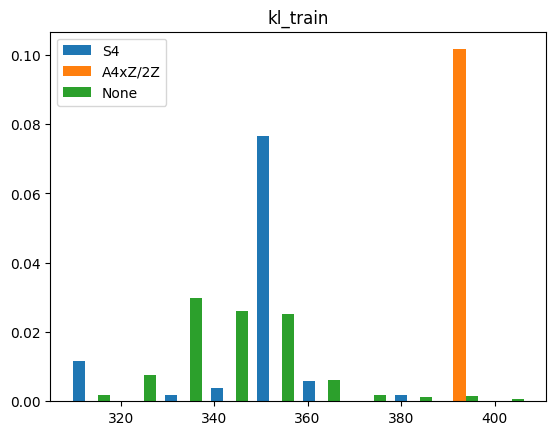

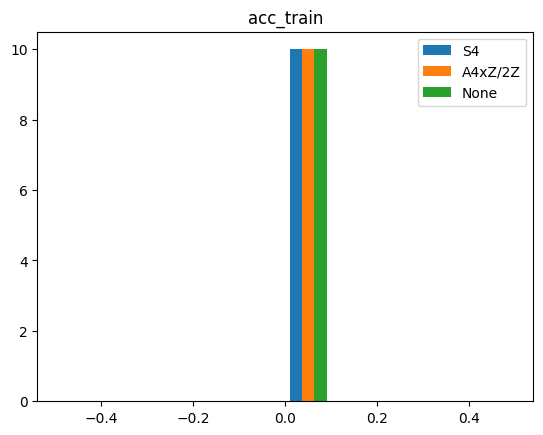

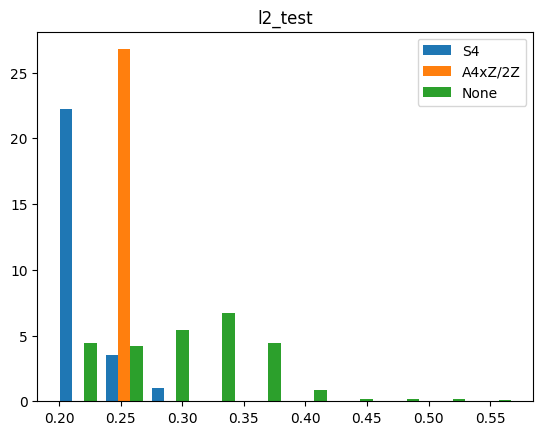

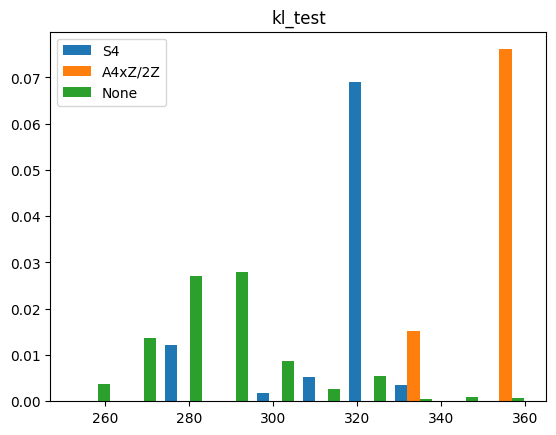

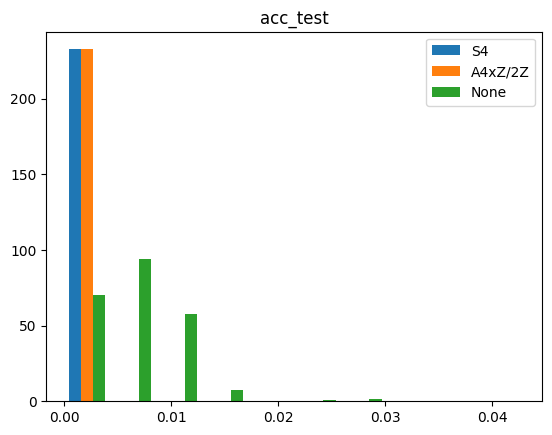

In [ ]:
# for tv, name in zip([kl_tv, l2_tv, acc_tv], ['kl tv', 'l2 tv', 'acctv']):
for name, tv in tvs.items():
    g0_tv = tv[g0_grokked.cpu()]
    g1_tv = tv[g1_grokked.cpu()]
    none_tv = tv[~grokked.cpu()]
    plt.hist([a.numpy() for a in [g0_tv, g1_tv, none_tv]], bins=10, histtype='bar', density=True, label=['S4', 'A4xZ/2Z', 'None'])
    plt.title(name)
    # plt.xscale('log')
    plt.legend()
    plt.show()

In [59]:
tvs['acc_test'][g0_grokked.cpu()].mean(), tvs['acc_test'][g1_grokked.cpu()].mean(), tvs['acc_test'][~grokked.cpu()].mean()

(tensor(5.3721e-05), tensor(0.0004), tensor(0.0065))

In [76]:
loss_tv = dict()
z_test = einops.rearrange(data.groups[0].cayley_table, "a b -> (a b)").to(device)
for key, z in zip(['train', 'test'], [z_train, z_test]):
    loss_deltas = []
    for out0, out1 in zip(outs[key][:-1], outs[key][1:]):
        loss0 = get_cross_entropy(out0.to(device), z.to(device))
        loss1 = get_cross_entropy(out1.to(device), z.to(device))
        loss_deltas.append(t.abs(loss0 - loss1))
    loss_tv[key] = t.stack(loss_deltas)[:100].mean(dim=0)

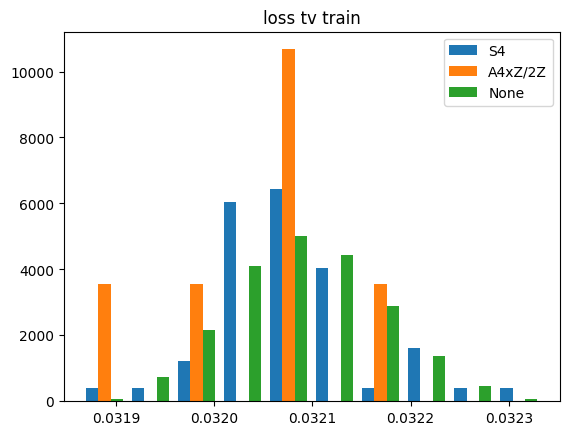

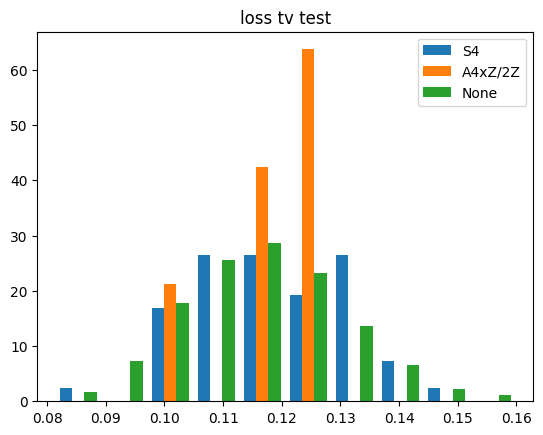

In [77]:
for key in ['train', 'test']:
    plt.hist(
        [loss_tv[key][a].detach().cpu() for a in [g0_grokked, g1_grokked, ~grokked]], 
        bins=10, histtype='bar', density=True, label=['S4', 'A4xZ/2Z', 'None']
    )
    plt.legend()
    plt.title(f'loss tv {key}')
    plt.show()